In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns; sns.set()
import zipfile

In [4]:
train = "order_products__train.csv"
products = 'products.csv'
departments = 'departments.csv'
aisles = 'aisles.csv'
prior= "order_products__prior.csv"
orders='orders.csv'


orders = zipfile.ZipFile("Data/"+orders+".zip","r")
products = zipfile.ZipFile("Data/"+products+".zip","r")
departments = zipfile.ZipFile("Data/"+departments+".zip","r")
aisles = zipfile.ZipFile("Data/"+aisles+".zip","r")
train = zipfile.ZipFile("Data/"+train+".zip","r")
prior=zipfile.ZipFile("Data/"+prior+".zip","r")

In [5]:
train = pd.read_csv(train.open('order_products__train.csv'))
prior =pd.read_csv(prior.open('order_products__prior.csv'))
products = pd.read_csv(products.open('products.csv'))
departments = pd.read_csv(departments.open('departments.csv'))
aisles = pd.read_csv(aisles.open('aisles.csv'))
orders = pd.read_csv(orders.open('orders.csv'))


In [6]:
# appending train with prior to obtain whole sample size 
full = prior.append(train)

In [7]:
# sorting values by order id to keep some structure
full.sort_values(by = 'order_id', inplace = True, kind = 'mergesort')

In [8]:
# merging orders and full to include time and product information
full= full.merge(orders, on = 'order_id', how = 'left')

In [9]:
# merging to substitute id for actual name
full = full.merge(products, on = 'product_id', how = 'left')

In [10]:
# merging to substitute id for actual name
full = full.merge(aisles, on = 'aisle_id', how = 'left')

In [11]:
# merging to substitute id for actual name
full = full.merge(departments, on = 'department_id', how = 'left')

In [12]:
# removing id in place of actual name 
full.pop('product_id')
full.pop('aisle_id')
full.pop('department_id')
full.head()

order_id  add_to_cart_order  ...                 aisle    department
0         1                  1  ...                yogurt    dairy eggs
1         1                  2  ...  other creams cheeses    dairy eggs
2         1                  3  ...      fresh vegetables       produce
3         1                  4  ...      fresh vegetables       produce
4         1                  5  ...   canned meat seafood  canned goods

[5 rows x 12 columns]

In [13]:
# reordering sequence of columns for easy lookup
full = full[[ 'order_id',
             'order_number',
             'user_id',
             'department',
             'aisle',
             'product_name',
             'add_to_cart_order',
             'days_since_prior_order',
             'order_dow',
             'order_hour_of_day',
             'reordered',
             'eval_set']]
full.head()

order_id  order_number  user_id  ... order_hour_of_day reordered eval_set
0         1             4   112108  ...                10         1    train
1         1             4   112108  ...                10         1    train
2         1             4   112108  ...                10         0    train
3         1             4   112108  ...                10         0    train
4         1             4   112108  ...                10         1    train

[5 rows x 12 columns]

In [14]:
# EDA

Text(0.5, 1.0, 'What department is purchased from the most?')

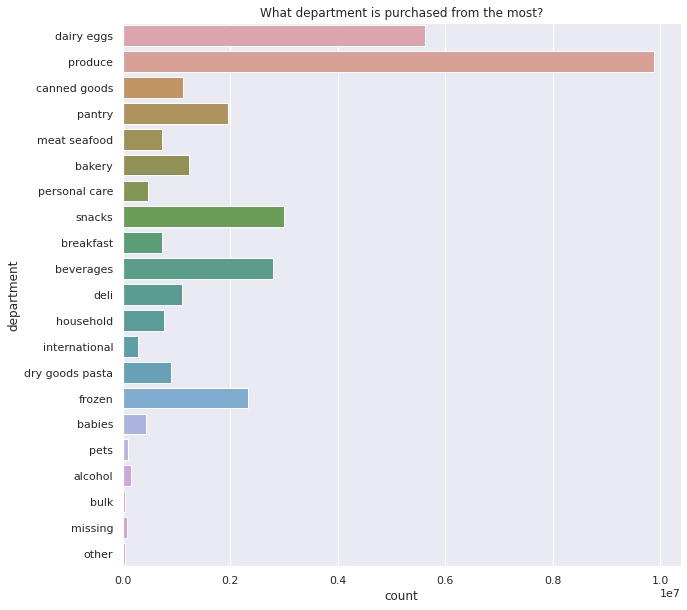

In [15]:
# How can we classify the items? produce offers the most
# Will this be evident in the recommended products?
plt.figure(figsize = (10,10))
sns.countplot(
            y = 'department',
            data = full,  
            orient = 'h', 
            saturation = 0.5,
            )
plt.title('What department is purchased from the most?')

In [16]:
# How many products are there?
total_products = products.shape[0]
total_products

49688

In [17]:
# How many aisles?
total_aisles = aisles.shape[0]
total_aisles

134

In [18]:
# How many departments?
total_departments = departments.shape[0]
total_departments

21

In [19]:
# creation of data for department and aisle comparison 
stock = full[['department', 'aisle', 'product_name']]
# changed from series to df to input into graph
total_units = pd.DataFrame(stock.groupby(['department','aisle']).size().sort_values())
# renaming unnamed column
total_units.reset_index(inplace = True)
total_units.rename(columns = { 0:'totals'}, inplace = True)
total_units.head()

department                aisle  totals
0         frozen         frozen juice    5147
1  personal care               beauty    6455
2         babies     baby accessories    8466
3         babies  baby bath body care    8909
4  personal care         eye ear care    9522

In [20]:
full.loc[(full['aisle'] == 'missing') | (full['department'] == 'missing')]
# 77396 observations contain "missing"  
# because of the 1258 products containing "missing" in aisle and/or department column

order_id  order_number  ...  reordered eval_set
654             75             1  ...          0    prior
1511           154            68  ...          1    prior
1512           154            68  ...          0    prior
2126           226             4  ...          0    train
4121           420            37  ...          0    prior
...            ...           ...  ...        ...      ...
33816839   3420851            79  ...          1    train
33816856   3420852            40  ...          0    prior
33818714   3421036            21  ...          0    prior
33818837   3421050            31  ...          0    prior
33818925   3421059             7  ...          0    prior

[77396 rows x 12 columns]

In [21]:
# visualization for better interpretation and quicker comparisons
fig, ax = plt.subplots(figsize=(20,65), dpi= 325)
# Initial setup for the background
ax.hlines(
          y=total_units.aisle, 
          color='gray', 
          xmin=350, 
          xmax=1050, 
          alpha=0.3,
          linewidth=2,
          linestyles='dashdot'
          )

plot_kws = {'s':500}
# controls marker size passed down to plt.scatter at draw time
sns.scatterplot(
            x= 'totals',
            y='aisle',
            hue='department', 
            data=total_units, 
            palette= 'colorblind', 
            **plot_kws
           )

# Title, Label, Ticks and Legend

ax.set_title(
            'Product Aisle Items',
             fontdict={'size':63}
            )
plt.legend(
           loc = 'lower right',
           prop={'size': 50},
           markerscale = 5
          )

# x axis
ax.set_xlim(0, 1300)
ax.set_xlabel('Items Available', fontdict={'size':50})
ax.set_xticklabels([0,200,400,600,800,1000,1200], fontdict = {'size': 36})
ax.tick_params(axis = 'x', labelsize = 50, which = 'major')

# y axis
ax.tick_params(axis = 'y', labelsize = 25, which ='major')
plt.ylabel('Aisle', fontdict = {'size':21})
ax.set_yticks(total_units.aisle)
ax.set_yticklabels(total_units.aisle.str.title(),
                   fontdict={'horizontalalignment': 'right'})



plt.show()

In [22]:
# top 20 products sold
top_20_items = full.product_name.value_counts().head(20)
top_20_items

Banana                      491291
Bag of Organic Bananas      394930
Organic Strawberries        275577
Organic Baby Spinach        251705
Organic Hass Avocado        220877
Organic Avocado             184224
Large Lemon                 160792
Strawberries                149445
Limes                       146660
Organic Whole Milk          142813
Organic Raspberries         142603
Organic Yellow Onion        117716
Organic Garlic              113936
Organic Zucchini            109412
Organic Blueberries         105026
Cucumber Kirby               99728
Organic Fuji Apple           92889
Organic Lemon                91251
Organic Grape Tomatoes       88078
Apple Honeycrisp Organic     87272
Name: product_name, dtype: int64

Text(0.5, 1.0, 'What items are the most purchased?')

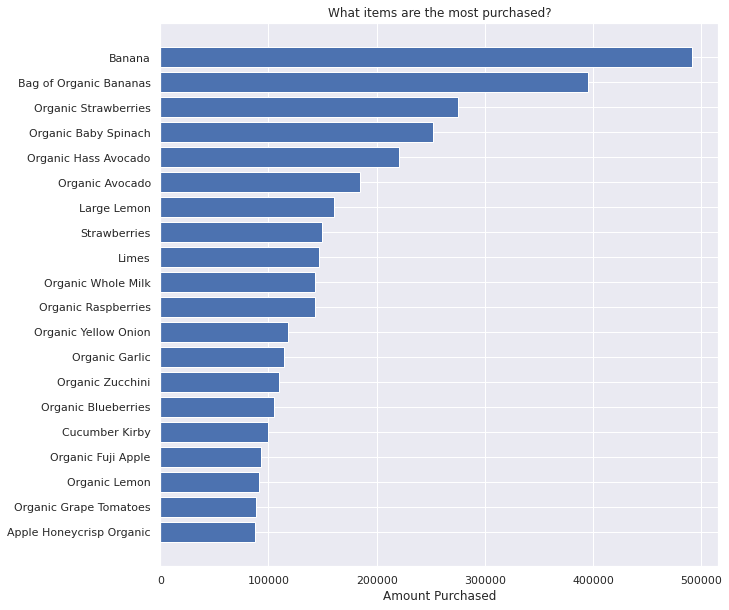

In [23]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(
    top_20_items.index,
    top_20_items, 
    align='center'
        )
# labels read top-to-bottom
ax.invert_yaxis() 
ax.set_xlabel('Amount Purchased')
ax.set_title('What items are the most purchased?')

In [24]:
# What items are reordered the most? only a few slight differences
reordered_amt = full.loc[full['reordered'] == 1].groupby('product_name').size()
reordered_amt.sort_values(inplace = True, ascending = False)
top_20_reordered = reordered_amt.head(20)

Text(0.5, 1.0, 'What items are reordered the most ?')

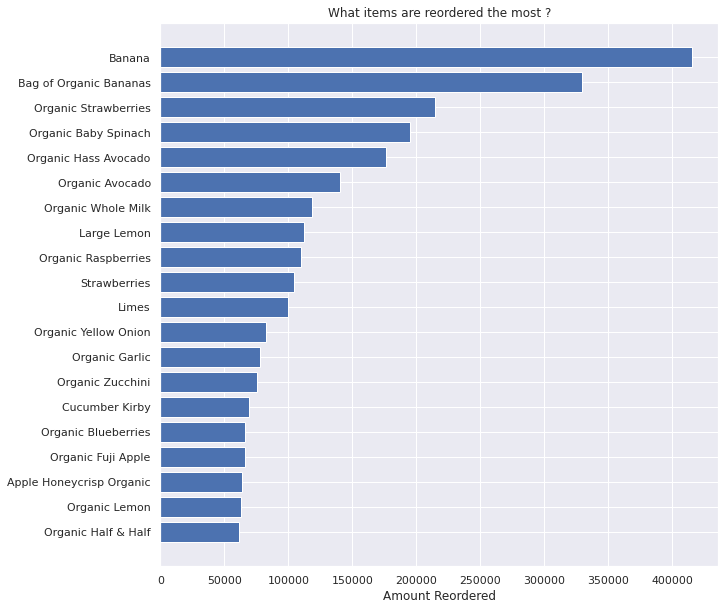

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(top_20_reordered.index, top_20_reordered, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Amount Reordered')
ax.set_title('What items are reordered the most ?')

In [26]:
#What items are usually chosen first?
first_picks = full.loc[full['add_to_cart_order'] == 1].groupby('product_name').size()
first_picks.sort_values(inplace = True, ascending = False)
first_picks_top_20 = first_picks.head(20)

Text(0.5, 1.0, 'What items are chosen first?')

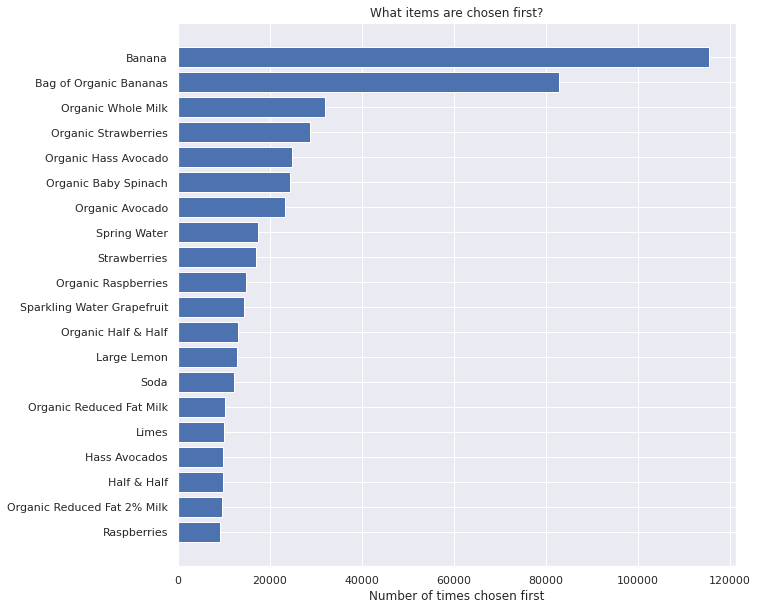

In [27]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(first_picks_top_20.index,first_picks_top_20, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of times chosen first')
ax.set_title('What items are chosen first?')

In [28]:
# How often is a product reordered
reorder_ratio = full.reordered.value_counts()

Text(0, 0.5, '')

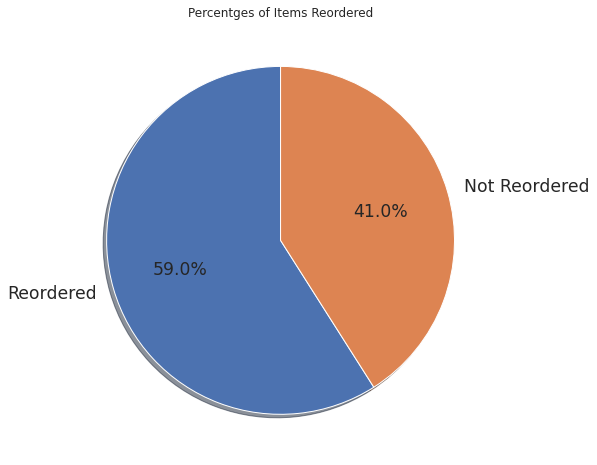

In [29]:
# Plotting pie chart, kwargs draws from pyplot.pie
pie_kwargs = {'startangle': 90, 
              'labels' : ['Reordered','Not Reordered'],
              'autopct' : '%.1f%%',
               'fontsize' : 'x-large'
             }
reorder_ratio.plot(kind = 'pie', 
                   figsize = (8,8),
                   title = 'Percentges of Items Reordered',
                   shadow = True,
                   **pie_kwargs).set_ylabel('')

In [30]:
# order amount per user
order_amt = full.groupby('user_id').order_number.max()
order_amt

user_id
1         11
2         15
3         12
4          5
5          5
          ..
206205     4
206206    67
206207    16
206208    49
206209    14
Name: order_number, Length: 206209, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(17.226658390273947, 0.08, 'mean = 16.23')

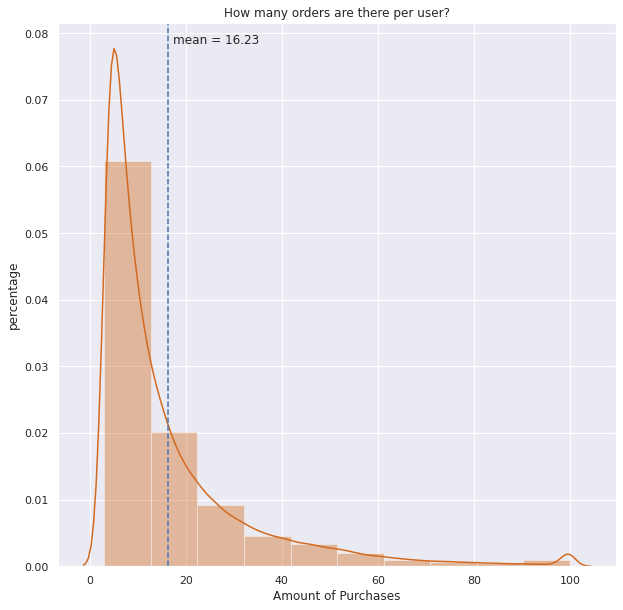

In [31]:
# order amount per user
plt.figure(figsize = (10,10))
sns.distplot(
            order_amt, 
            kde = True, 
            bins = 10, 
            color = 'chocolate', 
            axlabel = 'Amount of Purchases',
            )
plt.title('How many orders are there per user?')
plt.ylabel('percentage')
plt.axvline(order_amt.mean(), linestyle='dashed',)
plt.text(
    order_amt.mean() + 1,
    0.08,
    'mean = ' + str(round(order_amt.mean(), 2)),
    verticalalignment = 'top'
    )

In [32]:
# amount of items purchased in each order
items_per_purchase = full.groupby('order_id').add_to_cart_order.max()
items_per_purchase

order_id
1           8
2           9
3           8
4          13
5          26
           ..
3421079     1
3421080     9
3421081     7
3421082     7
3421083    10
Name: add_to_cart_order, Length: 3346083, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(18, 0.06, 'mean = 10.11')

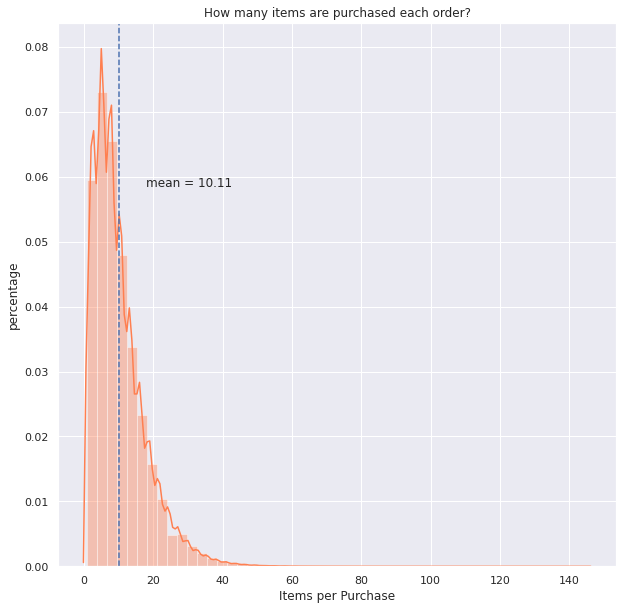

In [33]:
# items per purchase
plt.figure(figsize = (10,10))
sns.distplot(
            items_per_purchase, 
            kde = True, 
            color = 'coral', 
            axlabel = 'Items per Purchase',
            )
plt.title('How many items are purchased each order?')
plt.ylabel('percentage')
plt.axvline(items_per_purchase.mean(), linestyle='dashed',)
plt.text(18,
         0.06,
         'mean = '+ str(round(items_per_purchase.mean(), 2)),
         verticalalignment = 'top'
        )